In [ ]:
cd /content/drive/MyDrive/[Projects]/AI Hub/Pose Detection 기반 실시간 낙상 감지 시스템 개발/Data

/content/drive/MyDrive/[Projects]/AI Hub/Pose Detection 기반 실시간 낙상 감지 시스템 개발/Data


In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('output_train_near_fall.csv')
val_df = pd.read_csv('output_val_near_fall.csv')

In [ ]:
train_df.head()

,file,frame,label,nose_x,nose_y,nose_score,left_eye_x,left_eye_y,left_eye_score,right_eye_x,...,vel_24,vel_25,vel_26,vel_27,vel_28,vel_29,vel_30,vel_31,vel_32,vel_33
0,02077_H_A_N_C1.mp4,0,0,433.201904,137.339722,0.123687,433.536316,133.542877,0.128915,435.075867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,02077_H_A_N_C1.mp4,1,0,432.706665,139.028076,0.119133,432.644653,135.262482,0.107487,434.446259,...,0.002232,0.011634,0.007836,-0.092934,0.031258,-0.071982,-0.008529,-0.175243,0.031343,-0.128266
2,02077_H_A_N_C1.mp4,2,0,432.811005,140.320831,0.082605,432.059906,136.109604,0.069186,433.391357,...,-0.007661,-0.001744,-0.028229,-0.060200,-0.029632,-0.057576,0.001561,-0.093113,-0.075447,-0.099412
3,02077_H_A_N_C1.mp4,3,0,431.418213,141.639893,0.084149,430.199036,137.462433,0.066609,431.576538,...,-0.002786,-0.013046,0.001224,-0.006818,0.007052,-0.027456,0.001277,-0.007434,0.024479,-0.040471
4,02077_H_A_N_C1.mp4,4,0,425.485809,142.749344,0.093535,424.375854,138.612152,0.070890,425.632202,...,0.000569,-0.017323,0.004953,-0.004367,0.016820,-0.031442,0.000893,-0.013368,0.034136,-0.048329


In [ ]:
val_df.head()

,file,frame,label,nose_x,nose_y,nose_score,left_eye_x,left_eye_y,left_eye_score,right_eye_x,...,vel_24,vel_25,vel_26,vel_27,vel_28,vel_29,vel_30,vel_31,vel_32,vel_33
0,02366_H_A_SY_C7.mp4,0,0,713.038818,227.906616,0.888511,717.906677,223.113281,0.924195,712.661621,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,02366_H_A_SY_C7.mp4,1,0,713.864014,227.872955,0.891030,718.779541,223.278336,0.923748,713.481201,...,-0.112955,0.161715,0.381819,-6.715754,-0.675559,-6.430945,-0.776255,-13.177279,-1.453158,-12.381730
2,02366_H_A_SY_C7.mp4,2,0,713.848267,228.159546,0.878212,718.976013,223.683899,0.919033,714.304138,...,1.789286,-0.356893,-1.302473,44.364693,3.609579,43.319714,6.900908,86.952545,8.649220,82.829675
3,02366_H_A_SY_C7.mp4,3,0,714.660950,228.523041,0.877201,720.220764,224.102509,0.916390,714.938904,...,-0.254966,0.300454,1.205053,-29.518763,-1.438265,-28.774251,-4.255548,-58.087553,-5.112392,-55.332498
4,02366_H_A_SY_C7.mp4,4,0,714.568359,229.067261,0.866399,720.067688,224.768997,0.911367,715.088623,...,-0.100095,0.065922,-0.171281,-7.418314,-0.893028,-7.207498,-1.852572,-14.585486,-1.860137,-13.805935


In [ ]:
import torch
import random

def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
COCO_EDGES = [
    (0,1),(1,2),(2,3),(3,4),          # Right arm
    (0,5),(5,6),(6,7),(7,8),          # Left arm
    (0,9),(9,10),(10,11),              # Right leg
    (0,12),(12,13),(13,14),            # Left leg
    (0,15),(15,16)                     # Head
]

In [ ]:
import numpy as np

def build_adjacency(num_nodes=17, edges=COCO_EDGES):
    A = np.zeros((num_nodes, num_nodes))

    for i, j in edges:
        A[i, j] = 1
        A[j, i] = 1

    for i in range(num_nodes):
        A[i, i] = 1

    return A

In [ ]:
import torch

class Graph:
    def __init__(self, num_nodes=17, edges=None):
        self.num_nodes = num_nodes
        self.edges = edges
        self.A = self.get_adjacency()

    def get_adjacency(self):
        A = build_adjacency(self.num_nodes, self.edges)
        A = torch.tensor(A, dtype=torch.float32)
        return A

In [ ]:
def make_stgcn_input(seq):
    '''
    seq: (T, 68) = [x, y, dx, dy] * 17
    return: (4, T, 17)
    '''
    T = seq.shape[0]
    data = seq.reshape(T, 17, 4) # (T, V, C)
    data = data.transpose(2, 0, 1) # (C, T, V)
    return data

In [ ]:
from torch.utils.data import Dataset

class PoseSTGCNDataset(Dataset):
    def __init__(self, x, y):
        '''
        x: list of (T, 68)
        y: labels (0: normal, 1: near-fall, 2: fall)
        '''
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = make_stgcn_input(self.x[idx])
        y = self.y[idx]

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y)

In [ ]:
import torch.nn as nn

class SpatialGraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, A):
        super().__init__()

        self.register_buffer('A', A)
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1
        )

    def forward(self, x):
        '''
        x: (N, C, T, V)
        '''

        x = torch.einsum('nctv,vw->nctw', x, self.A)

        x = self.conv(x)
        return x

In [ ]:
class TemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, stride=1):
        super().__init__()

        padding = (kernel_size - 1) // 2

        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=(kernel_size, 1),
            stride=(stride, 1),
            padding=(padding, 0)
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

In [ ]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()

        if in_channels == out_channels and stride == 1:
            self.residual = nn.Identity()
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=(stride, 1)
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        return self.residual(x)

In [ ]:
class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, A, kernel_size=9, stride=1):
        super().__init__()

        self.gcn = SpatialGraphConv(
            in_channels,
            out_channels,
            A
        )

        self.tcn = TemporalConv(
            out_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride
        )

        self.residual = Residual(
            in_channels,
            out_channels,
            stride

        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        res = self.residual(x)
        x = self.gcn(x)
        x = self.tcn(x)
        x = x + res
        x = self.relu(x)
        return x

In [ ]:
import torch.nn.functional as F

class STGCN(nn.Module):
    def __init__(self, in_channels=4, num_classes=3, graph=None):
        super().__init__()

        A = graph.A

        self.data_bn = nn.BatchNorm1d(in_channels * A.size(0))

        self.layers = nn.ModuleList([
            STGCNBlock(in_channels, 64, A),
            STGCNBlock(64, 64, A),
            STGCNBlock(64, 64, A),

            STGCNBlock(64, 128, A, stride=2),
            STGCNBlock(128, 128, A),
            STGCNBlock(128, 128, A),

            STGCNBlock(128, 256, A, stride=2),
            STGCNBlock(256, 256, A),
            STGCNBlock(256, 256, A)
        ])

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        N, C, T, V = x.shape

        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(N, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, V, C, T)
        x = x.permute(0, 2, 3, 1)

        for layer in self.layers:
            x = layer(x)

        x = x.mean(dim=3).mean(dim=2)

        return self.fc(x)

In [ ]:
POSE_NORM_COLS = [f'pose_norm_{i}' for i in range(51)]
VEL_COLS       = [f'vel_{i}' for i in range(34)]

FEATURE_COLS = POSE_NORM_COLS + VEL_COLS

In [ ]:
def split_pose_vel(feature_85):
    pose = feature_85[:51].reshape(17, 3)
    vel = feature_85[51:].reshape(17, 2)

    pose_xy = pose[:, :2]
    return pose_xy, vel

In [ ]:
def make_stgcn_sequence(df, window_size, feature_cols, label_col='label_3class'):
    x, y = [], []

    for file, group in df.groupby('file'):
        group = group.sort_values('frame')
        feats = group[feature_cols].values
        labels = group[label_col].values

        for i in range(len(group) - window_size):
            seq = feats[i:i+window_size]

            frames = []
            for f in seq:
                pose_xy, vel_xy = split_pose_vel(f)

                frame = np.concatenate([pose_xy, vel_xy], axis=1)
                frames.append(frame)

            frames = np.stack(frames)
            frames = frames.transpose(2, 0, 1)

            x.append(frames)
            y.append(labels[i + window_size - 1])

    return np.array(x), np.array(y)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight

def train_stgcn_3class(x, y, x_val, y_val,
                       graph,
                       epochs=20, batch_size=32, lr=1e-3):

    """
    x, x_val: (N, 4, T, 17)
    y, y_val: (N,)
    graph: Graph 객체
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ✅ ST-GCN 모델 (네가 구현한 버전)
    model = STGCN(
        in_channels=4,
        num_classes=3,
        graph=graph
    ).to(device)

    # class weight (Near-Fall 중요)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1, 2]),
        y=y
    )

    loss_fn = nn.CrossEntropyLoss(
        weight=torch.tensor(class_weights, dtype=torch.float32).to(device)
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # ❌ to_stgcn_input() 제거 (이미 변환됨)

    train_ds = TensorDataset(
        torch.tensor(x, dtype=torch.float32),
        torch.tensor(y, dtype=torch.long)
    )

    val_ds = TensorDataset(
        torch.tensor(x_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.long)
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for seq, label in train_loader:
            seq = seq.to(device)      # (N,4,T,17)
            label = label.to(device)

            logits = model(seq)
            loss = loss_fn(logits, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch+1}] loss={total_loss/len(train_loader):.4f}")

    return model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_stgcn_3class(model, x_val, y_val):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    loader = DataLoader(
        TensorDataset(torch.tensor(x_val).float()),
        batch_size=32,
        shuffle=False
    )

    preds = []

    with torch.no_grad():
        for seq, in loader:
            seq = seq.to(device)
            logits = model(seq)
            pred = torch.argmax(logits, dim=1)
            preds.extend(pred.cpu().numpy())

    preds = np.array(preds)
    y_val = np.array(y_val)

    print(classification_report(
        y_val, preds,
        target_names=["Normal","Near-Fall","Fall"]
    ))
    print(confusion_matrix(y_val, preds))

    return {
        "F1_macro": f1_score(y_val, preds, average="macro", zero_division=0),
        "F1_weighted": f1_score(y_val, preds, average="weighted", zero_division=0),
        "Precision_macro": precision_score(y_val, preds, average="macro", zero_division=0),
        "Recall_macro": recall_score(y_val, preds, average="macro", zero_division=0)
    }

In [ ]:
window_to_model = {}
results = []

In [ ]:
WINDOW = 10
fix_seed(42)

x_train, y_train = make_stgcn_sequence(
    train_df,
    window_size=WINDOW,
    feature_cols=FEATURE_COLS,
    label_col='label_3class'
)

x_val, y_val = make_stgcn_sequence(
    val_df,
    window_size=WINDOW,
    feature_cols=FEATURE_COLS,
    label_col='label_3class'
)

graph = Graph(num_nodes=17, edges=COCO_EDGES)

model_stgcn_10 = train_stgcn_3class(
    x_train, y_train,
    x_val, y_val,
    graph=graph,
    epochs=10,
    batch_size=32,
    lr=1e-3
)

window_to_model[WINDOW] = model_stgcn_10

metrics = evaluate_stgcn_3class(model_stgcn_10, x_val, y_val)

results.append({
    "Window": WINDOW,
    "Model": "STGCN_3Class",
    **metrics
})

[Epoch 1] loss=0.7796
[Epoch 2] loss=0.6285
[Epoch 3] loss=0.5969
[Epoch 4] loss=0.5768
[Epoch 5] loss=0.5644
[Epoch 6] loss=0.5553
[Epoch 7] loss=0.5402
[Epoch 8] loss=0.5338
[Epoch 9] loss=0.5295
[Epoch 10] loss=0.5170
              precision    recall  f1-score   support

      Normal       0.98      0.90      0.94     48454
   Near-Fall       0.31      0.65      0.42      1754
        Fall       0.42      0.70      0.53      3072

    accuracy                           0.88     53280
   macro avg       0.57      0.75      0.63     53280
weighted avg       0.92      0.88      0.90     53280

[[43537  2266  2651]
 [  312  1139   303]
 [  676   248  2148]]


In [ ]:
WINDOW = 20
fix_seed(42)

x_train, y_train = make_stgcn_sequence(
    train_df,
    window_size=WINDOW,
    feature_cols=FEATURE_COLS,
    label_col='label_3class'
)

x_val, y_val = make_stgcn_sequence(
    val_df,
    window_size=WINDOW,
    feature_cols=FEATURE_COLS,
    label_col='label_3class'
)

graph = Graph(num_nodes=17, edges=COCO_EDGES)

model_stgcn_20 = train_stgcn_3class(
    x_train, y_train,
    x_val, y_val,
    graph=graph,
    epochs=10,
    batch_size=32,
    lr=1e-3
)

window_to_model[WINDOW] = model_stgcn_20

metrics = evaluate_stgcn_3class(model_stgcn_20, x_val, y_val)

results.append({
    "Window": WINDOW,
    "Model": "STGCN_3Class",
    **metrics
})

[Epoch 1] loss=0.8190
[Epoch 2] loss=0.6246
[Epoch 3] loss=0.5833
[Epoch 4] loss=0.5605
[Epoch 5] loss=0.5449
[Epoch 6] loss=0.5335
[Epoch 7] loss=0.5225
[Epoch 8] loss=0.5112
[Epoch 9] loss=0.5046
[Epoch 10] loss=0.4939
              precision    recall  f1-score   support

      Normal       0.98      0.85      0.91     42683
   Near-Fall       0.27      0.76      0.40      1613
        Fall       0.40      0.76      0.52      3064

    accuracy                           0.84     47360
   macro avg       0.55      0.79      0.61     47360
weighted avg       0.92      0.84      0.87     47360

[[36431  2943  3309]
 [  203  1221   189]
 [  428   319  2317]]


In [ ]:
WINDOW = 30
fix_seed(42)

x_train, y_train = make_stgcn_sequence(
    train_df,
    window_size=WINDOW,
    feature_cols=FEATURE_COLS,
    label_col='label_3class'
)

x_val, y_val = make_stgcn_sequence(
    val_df,
    window_size=WINDOW,
    feature_cols=FEATURE_COLS,
    label_col='label_3class'
)

graph = Graph(num_nodes=17, edges=COCO_EDGES)

model_stgcn_30 = train_stgcn_3class(
    x_train, y_train,
    x_val, y_val,
    graph=graph,
    epochs=10,
    batch_size=32,
    lr=1e-3
)

window_to_model[WINDOW] = model_stgcn_30

metrics = evaluate_stgcn_3class(model_stgcn_30, x_val, y_val)

results.append({
    "Window": WINDOW,
    "Model": "STGCN_3Class",
    **metrics
})

[Epoch 1] loss=0.8458
[Epoch 2] loss=0.6678
[Epoch 3] loss=0.5909
[Epoch 4] loss=0.5556
[Epoch 5] loss=0.5363
[Epoch 6] loss=0.5189
[Epoch 7] loss=0.5046
[Epoch 8] loss=0.4898
[Epoch 9] loss=0.4782
[Epoch 10] loss=0.4673
              precision    recall  f1-score   support

      Normal       0.94      0.94      0.94     37088
   Near-Fall       0.38      0.49      0.43      1368
        Fall       0.40      0.36      0.38      2984

    accuracy                           0.88     41440
   macro avg       0.57      0.60      0.58     41440
weighted avg       0.88      0.88      0.88     41440

[[34756   848  1484]
 [  538   675   155]
 [ 1660   245  1079]]


In [ ]:
WINDOW = 40
fix_seed(42)

x_train, y_train = make_stgcn_sequence(
    train_df,
    window_size=WINDOW,
    feature_cols=FEATURE_COLS,
    label_col='label_3class'
)

x_val, y_val = make_stgcn_sequence(
    val_df,
    window_size=WINDOW,
    feature_cols=FEATURE_COLS,
    label_col='label_3class'
)

graph = Graph(num_nodes=17, edges=COCO_EDGES)

model_stgcn_40 = train_stgcn_3class(
    x_train, y_train,
    x_val, y_val,
    graph=graph,
    epochs=10,
    batch_size=32,
    lr=1e-3
)

window_to_model[WINDOW] = model_stgcn_40

metrics = evaluate_stgcn_3class(model_stgcn_40, x_val, y_val)

results.append({
    "Window": WINDOW,
    "Model": "STGCN_3Class",
    **metrics
})

[Epoch 1] loss=0.9075
[Epoch 2] loss=0.6671
[Epoch 3] loss=0.5848
[Epoch 4] loss=0.5424
[Epoch 5] loss=0.5199
[Epoch 6] loss=0.5048
[Epoch 7] loss=0.4904
[Epoch 8] loss=0.4760
[Epoch 9] loss=0.4650
[Epoch 10] loss=0.4552
              precision    recall  f1-score   support

      Normal       0.97      0.87      0.92     31500
   Near-Fall       0.23      0.76      0.35      1116
        Fall       0.50      0.65      0.56      2904

    accuracy                           0.85     35520
   macro avg       0.57      0.76      0.61     35520
weighted avg       0.91      0.85      0.87     35520

[[27343  2391  1766]
 [  139   846   131]
 [  579   440  1885]]


In [ ]:
WINDOW = 50
fix_seed(42)

x_train, y_train = make_stgcn_sequence(
    train_df,
    window_size=WINDOW,
    feature_cols=FEATURE_COLS,
    label_col='label_3class'
)

x_val, y_val = make_stgcn_sequence(
    val_df,
    window_size=WINDOW,
    feature_cols=FEATURE_COLS,
    label_col='label_3class'
)

graph = Graph(num_nodes=17, edges=COCO_EDGES)

model_stgcn_50 = train_stgcn_3class(
    x_train, y_train,
    x_val, y_val,
    graph=graph,
    epochs=10,
    batch_size=32,
    lr=1e-3
)

window_to_model[WINDOW] = model_stgcn_50

metrics = evaluate_stgcn_3class(model_stgcn_50, x_val, y_val)

results.append({
    "Window": WINDOW,
    "Model": "STGCN_3Class",
    **metrics
})

[Epoch 1] loss=0.8659
[Epoch 2] loss=0.6424
[Epoch 3] loss=0.5586
[Epoch 4] loss=0.4872
[Epoch 5] loss=0.4522
[Epoch 6] loss=0.4320
[Epoch 7] loss=0.4142
[Epoch 8] loss=0.3990
[Epoch 9] loss=0.3876
[Epoch 10] loss=0.3738
              precision    recall  f1-score   support

      Normal       0.98      0.93      0.95     26918
   Near-Fall       0.32      0.69      0.44       810
        Fall       0.54      0.69      0.60      1872

    accuracy                           0.90     29600
   macro avg       0.61      0.77      0.66     29600
weighted avg       0.93      0.90      0.92     29600

[[24918  1008   992]
 [  133   559   118]
 [  391   188  1293]]


In [ ]:
result_df = pd.DataFrame(results)
result_df

,Window,Model,F1_macro,F1_weighted,Precision_macro,Recall_macro
0,10,STGCN_3Class,0.627789,0.895838,0.570207,0.749038
1,20,STGCN_3Class,0.612061,0.870865,0.551263,0.788900
2,30,STGCN_3Class,0.582589,0.881688,0.573097,0.597380
3,40,STGCN_3Class,0.611677,0.871430,0.567635,0.758400
4,50,STGCN_3Class,0.664192,0.915739,0.612000,0.768843


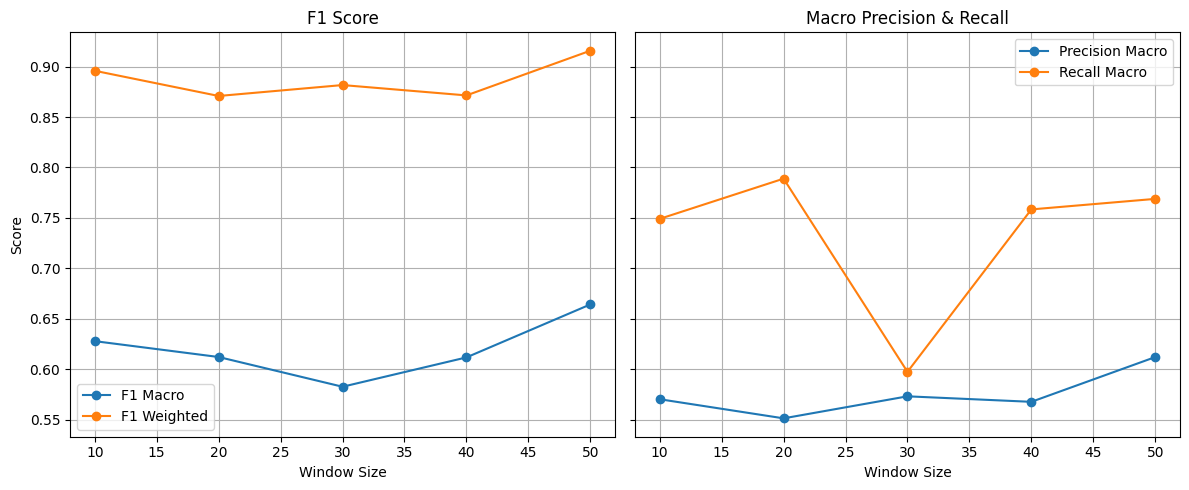

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# (1) F1 비교
axes[0].plot(result_df['Window'], result_df['F1_macro'],
             marker='o', label='F1 Macro')
axes[0].plot(result_df['Window'], result_df['F1_weighted'],
             marker='o', label='F1 Weighted')
axes[0].set_title('F1 Score')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('Score')
axes[0].legend()
axes[0].grid(True)

# (2) Precision / Recall (Macro)
axes[1].plot(result_df['Window'], result_df['Precision_macro'],
             marker='o', label='Precision Macro')
axes[1].plot(result_df['Window'], result_df['Recall_macro'],
             marker='o', label='Recall Macro')
axes[1].set_title('Macro Precision & Recall')
axes[1].set_xlabel('Window Size')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()